In [2]:
import pandas as pd

# news
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
# users
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [11]:
# vectorize news

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np
import nltk

# download resource
nltk.download('stopwords')

from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximdoroshenko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# additional stopwords for quality improve

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)
news['title']

<ipython-input-13-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
from gensim.models import LdaModel

# train
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [17]:
# save
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.07294867),
 (5, 0.06486633),
 (13, 0.1975221),
 (15, 0.158586),
 (16, 0.48459035)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: рост всё экономика рынок жизнь проект новый
topic_1: nn станция университет nnn армия академия газета
topic_2: путин владимир тема песок пресссекретарить запуск лауреат
topic_3: температура завод градус погода москва билет вино
topic_4: газ турция турецкий администрация франция лодка французский
topic_5: сша американский военный поверхность штат россия испытание
topic_6: гражданин болезнь космос топливо глава активность введение
topic_7: автор товар индия сопровождать концерн сооружение корь
topic_8: ребёнок земля всё область первый регион население
topic_9: мозг кровь выяснить эксперимент сотрудник задержать северный
topic_10: погибнуть операция решение банк nn произойти рф
topic_11: цена мужчина nn проверка планета общество тыс
topic_12: снижение сократиться золото аналог статистика золотой соотношение
topic_13: млн место рейтинг великобритания nn первый составить
topic_14: статья пациент лечение помощь исследование катастрофа проживать
topic_15: млрд рубль банк исследование

In [20]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.053012,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.069602,0.000000,0.000000,0.0,0.245015,0.0
1,4896,0.000000,0.324366,0.0,0.130110,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.264082,0.259329,0.000000,0.0,0.000000,0.0
2,4897,0.000000,0.000000,0.0,0.072946,0.0,0.064866,0.0,0.0,0.000000,...,0.158588,0.484596,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,4898,0.144413,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.167792,...,0.000000,0.000000,0.0,0.0,0.028238,0.000000,0.289275,0.0,0.000000,0.0
4,4899,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.133740,0.0,0.0,0.057206,0.000000,0.000000,0.0,0.783132,0.0


In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [25]:
get_user_embedding(user_articles_list)

array([0.02953833, 0.04006612, 0.03714061, 0.        , 0.        ,
       0.09707644, 0.05802896, 0.0195556 , 0.11943318, 0.05337802,
       0.07864696, 0.00578601, 0.        , 0.0058181 , 0.00181105,
       0.0558299 , 0.00756017, 0.        , 0.0648743 , 0.        ,
       0.        , 0.09422335, 0.        , 0.21791871, 0.        ])

In [26]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.091680,0.024140,0.010899,0.009718,0.007413,0.019058,0.063042,0.005407,0.175628,...,0.042928,0.009484,0.003365,0.121690,0.000000,0.004013,0.009605,0.025871,0.080885,0.000000
1,u108690,0.062812,0.006808,0.013665,0.000000,0.003240,0.067304,0.101531,0.005295,0.109008,...,0.071552,0.000000,0.000000,0.208509,0.007721,0.000000,0.040764,0.000000,0.112596,0.000000
2,u108339,0.032261,0.029742,0.000000,0.016585,0.007681,0.038740,0.108874,0.013619,0.094738,...,0.096024,0.002485,0.000000,0.027970,0.004162,0.000000,0.033149,0.000000,0.183890,0.003194


In [28]:
# users churn prediction

target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.091680,0.024140,0.010899,0.009718,0.007413,0.019058,0.063042,0.005407,0.175628,...,0.009484,0.003365,0.121690,0.000000,0.004013,0.009605,0.025871,0.080885,0.000000,0
1,u108690,0.062812,0.006808,0.013665,0.000000,0.003240,0.067304,0.101531,0.005295,0.109008,...,0.000000,0.000000,0.208509,0.007721,0.000000,0.040764,0.000000,0.112596,0.000000,1
2,u108339,0.032261,0.029742,0.000000,0.016585,0.007681,0.038740,0.108874,0.013619,0.094738,...,0.002485,0.000000,0.027970,0.004162,0.000000,0.033149,0.000000,0.183890,0.003194,1


In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [108]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [109]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([2.13991050e-01, 7.51265836e-04, 9.19589070e-01, 1.57437844e-01,
       1.45553393e-02, 7.97225094e-04, 9.29180822e-02, 4.68946345e-02,
       1.67446678e-02, 5.69451508e-01])

In [110]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

In [111]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.344693, F-Score=0.799, Precision=0.787, Recall=0.812


In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1701   54]
 [  47  198]]


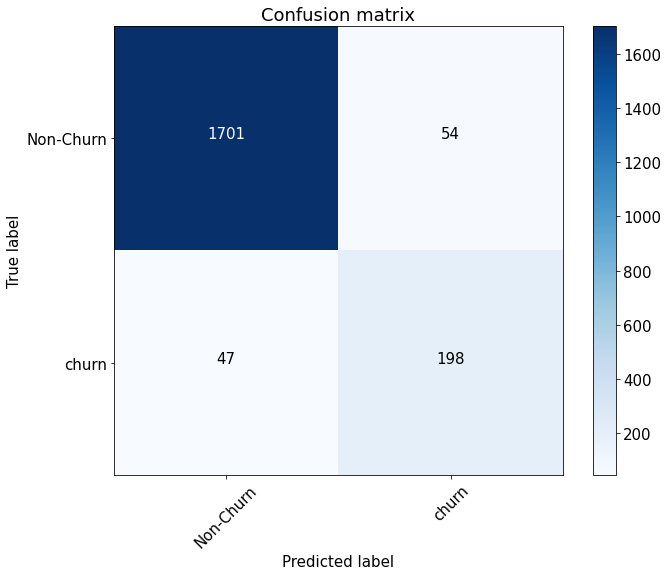

In [113]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [114]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9743961858247572

In [115]:
values_for_mean = [precision[ix], recall[ix], thresholds[ix], fscore[ix], roc_auc]

### Задание 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [116]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [117]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_test, preds)

values_for_median = [precision[ix], recall[ix], thresholds[ix], fscore[ix], roc_auc]

Best Threshold=0.329752, F-Score=0.832, Precision=0.835, Recall=0.829


In [118]:
roc_auc, values_for_median[-1] - values_for_mean[-1]

(0.9841618698761556, 0.009765684051398438)

Вывод: с медианой метрика чуть лучше.

### Задание 3
Повторить п.2, но используя уже не медиану, а max

In [119]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [120]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_test, preds)

values_for_max = [precision[ix], recall[ix], thresholds[ix], fscore[ix], roc_auc]
values_for_max[-1]

Best Threshold=0.344693, F-Score=0.799, Precision=0.787, Recall=0.812


0.9743961858247572

In [121]:
values_for_median[-1] - values_for_max[-1]

0.009765684051398438

Вывод: с медианой лучше.

### Задание 4
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [122]:
# Решение в Homework 2-TF-IDF
values_for_tfidf = [0.180312, 0.409, 0.311, 0.600, 0.8099191813477528]
values_for_tfidf[-1]

0.8099191813477528

### Задание 5
Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [123]:
values_for_mean.insert(0, 'Mean')
values_for_median.insert(0, 'Median')
values_for_max.insert(0, 'Max')
values_for_tfidf.insert(0, 'idf_mean')
pd.DataFrame(data=[values_for_mean, values_for_median, values_for_max, values_for_tfidf], columns=['Method', 'Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc'])

,Method,Threshold,F-Score,Precision,Recall,roc_auc
0,Mean,0.786561,0.812245,0.344693,0.799197,0.974396
1,Median,0.835391,0.828571,0.329752,0.831967,0.984162
2,Max,0.786561,0.812245,0.344693,0.799197,0.974396
3,idf_mean,0.180312,0.409000,0.311000,0.600000,0.809919


### Задание 6:
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Mean, Median и Max показали примерно одинаковые результаты. IDF показал результат хуже, т.к. LDA - вероятностная модель, которая расчитывает распределение вероятностей встречи слов и тем в документе. Веса для LDA не так важны. В отличие от LSA.